In [1]:
import pandas as pd
from multiprocessing import Pool, Process, Queue, current_process, parent_process
from datetime import datetime
# import time 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

In [2]:
m5_data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)

In [3]:
m5_data.columns = col_name =['target', 'ids', 'date', 'flag', 'user', 'text']

In [4]:
for col in col_name:
    print(m5_data[col].unique())

[0 4]
[1467810369 1467810672 1467810917 ... 2193601991 2193602064 2193602129]
['Mon Apr 06 22:19:45 PDT 2009' 'Mon Apr 06 22:19:49 PDT 2009'
 'Mon Apr 06 22:19:53 PDT 2009' ... 'Tue Jun 16 08:38:58 PDT 2009'
 'Tue Jun 16 08:39:00 PDT 2009' 'Tue Jun 16 08:40:50 PDT 2009']
['NO_QUERY']
['_TheSpecialOne_' 'scotthamilton' 'mattycus' ... 'EvolveTom'
 'AmandaMarie1028' 'bpbabe']
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 ... 'Are you ready for your MoJo Makeover? Ask me for details '
 'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur '
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']


## 분석 결과 : 
* 'flag' 항목은 drop 가능
* neutral sentiment는 없다.
  * 1~800,000 라인 = 긍정, 그 뒤로 부정

In [5]:
def remove_stopwords(text):
    """WordCloud STOPWORDS를 사용해 불용어 제거"""
    stopwords = set(STOPWORDS)  # WordCloud의 STOPWORDS 집합 가져오기
    words = text.split()  # 텍스트를 단어로 분리
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)  # 단어를 다시 합치기

In [6]:
def preprocess(txt: str) -> str:
    """
    Preprocess Twitter text data.
    일반적인 텍스트 이모지가 2~3character에 3연속 character인 것은 없다고 가정
    Args: txt (str): Original text from a tweet
    Return: (str): Cleaned and preprocessed text
    1. 링크형 텍스트 삭제
    2. @~~ 삭제
    3. 문장부호 삭제 (연속된 마침표 등등) —> You’re 같은게 깨져버리는지 유의 (보통 불용어로 처리되어 있음)
    4. &amp &quot &gt &lt —> 삭제
    5. 텍스트 이모티콘은 어떻게??  :), ;),  ^^, ~_~, 등등
    6. 안보이는 이스케이프 문자? (57915 라인에 존재) —> 제로 너비 문자?인 듯
    """
    # 0. 텍스트 이모티콘 처리 (보존)
    # 이모티콘 패턴
    emoji_pattern = r"[:;=8][-~]?[)D\(\[\]pP]|[\^]{2,}|~_~|T_T|xD|<3|:-?o|:-?O"
    emojis = re.findall(emoji_pattern, txt)  # 이모티콘 추출
    txt = re.sub(emoji_pattern, " ", txt)    # 원문에서 제거 후 보존

    # 1. 링크형 텍스트 삭제
    txt = re.sub(r"http\S+|www.\S+|https\S+", "", txt, flags=re.MULTILINE)
    
    # 2. @twitter_id 삭제
    txt = re.sub(r"@\w+", "", txt)
    
    # 3. 문장부호 삭제 (연속된 마침표 포함)
    txt = re.sub(r"[.,!?;:'\"()\[\]{}\-—…]+", " ", txt)
    
    # 4. 특수 HTML 엔티티 삭제
    txt = re.sub(r"&amp|&quot|&gt|&lt|&nbsp;", "", txt)
    
    # 5. 깨진 이스케이프 문자 및 공백 제거
    txt = re.sub(r"[\u200B-\u200D\uFEFF]", "", txt)  # Zero-width 문자 제거
    txt = re.sub(r"\s+", " ", txt).strip()           # 중복 공백 제거
    
    # 최종 클린 텍스트 생성
    return " ".join(txt.split() + emojis)

# 테스트 데이터
tweet = "Hello @user! Check this out: https://example.com 😊 😊 ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com"

# 결과 출력
print("Original text: ", tweet)
print("Preprocessed txt: ", preprocess(tweet))


Original text:  Hello @user! Check this out: https://example.com 😊 😊 ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com
Preprocessed txt:  Hello Check this out 😊 😊 Goodbye ^^ T_T ~_~


In [7]:
pos_data = m5_data[m5_data['target']==4][['text']]
neg_data = m5_data[m5_data['target']==0][['text']]

In [8]:
import numpy as np

vectorized_stopwords = np.vectorize(remove_stopwords)
vectorized_process = np.vectorize(preprocess)
pos_data['text'] = vectorized_stopwords(pos_data['text'])
pos_data['text'] = vectorized_process(pos_data['text'])

neg_data['text'] = vectorized_stopwords(neg_data['text'])
neg_data['text'] = vectorized_process(neg_data['text'])

In [9]:
wc = WordCloud()

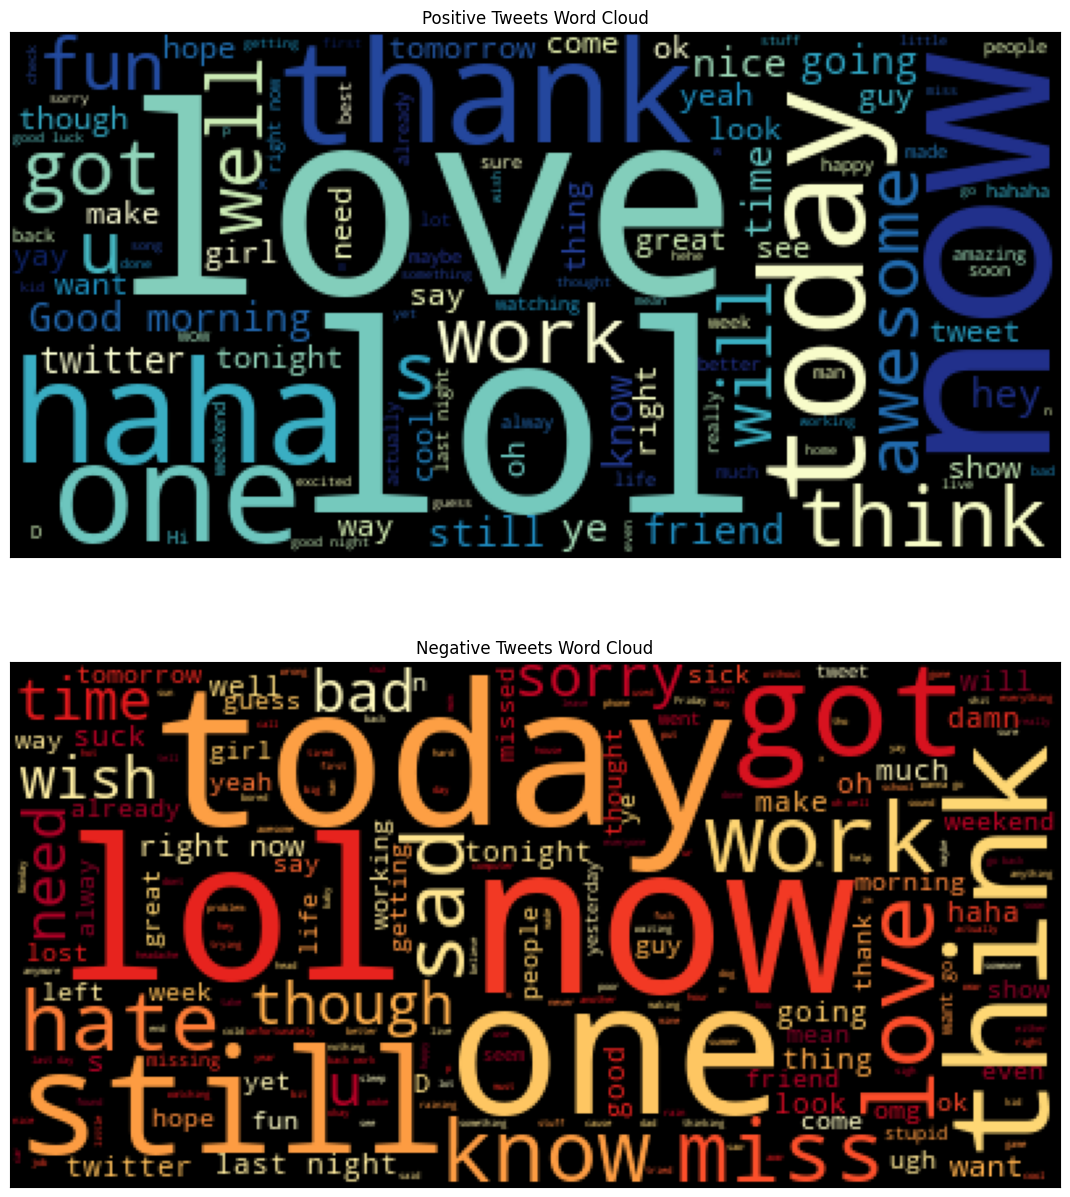

In [10]:
pos_txt = ' '.join(pos_data['text'])
# pos_dict = wc.generate(pos_txt).words_
neg_txt = ' '.join(neg_data['text'])

fig, axs = plt.subplots(2, 1, figsize = (15,15))
axs[0].imshow(WordCloud(max_words=200, colormap='YlGnBu').generate(pos_txt))
axs[0].yaxis.set_visible(False)
axs[0].xaxis.set_visible(False)
axs[0].set_title("Positive Tweets Word Cloud")

axs[1].imshow(WordCloud(max_words=200, colormap='YlOrRd').generate(neg_txt))
axs[1].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].set_title("Negative Tweets Word Cloud")

plt.show()

-------

# Sampling Process

In [11]:
from collections import Counter

In [12]:
pos_list = [word.lower() for text in pos_data['text'] for word in text.split()]
neg_list = [word.lower() for text in neg_data['text'] for word in text.split()]

In [13]:
pos_dict = Counter(pos_list)

In [14]:
neg_dict = Counter(neg_list)

## 공통 출현 단어 중 출현 횟수의 절댓값이 기준값 이하인 단어들을 제외하는 과정

In [15]:
common_key = set(pos_dict.keys()) & set(neg_dict.keys())

In [16]:
len(common_key)

85681

In [69]:
diff_senti = {}
for c in common_key:
    diff_senti[c] = abs(pos_dict[c] - neg_dict[c])
    
diff_senti_ratio = {}
maxpos = max(pos_dict.values())
maxneg = max(neg_dict.values())
for c in common_key:
    diff_senti_ratio[c] = abs(pos_dict[c]/maxpos - neg_dict[c]/maxneg)    

In [71]:
diff_avg = np.average(list(diff_senti.values()))
print("diff_avg: ", diff_avg)

diff_std = np.std(list(diff_senti.values()))
print("diff_std: ", diff_std)

diff_avg_ratio = np.average(list(diff_senti_ratio.values()))
print("diff_avg_ratio: ", diff_avg_ratio)

diff_std_ratio = np.std(list(diff_senti_ratio.values()))
print("diff_std_ratio: ", diff_std_ratio)

diff_avg:  31.210279992063583
diff_std:  391.52938685888796
diff_avg_ratio:  0.0005810789268403882
diff_std_ratio:  0.007294577209561627


In [73]:
threshold = diff_avg + diff_std * 2
print(threshold)

threshold_ratio = diff_avg_ratio + diff_std_ratio * 2
print(threshold_ratio)

814.2690537098395
0.015170233345963641


In [74]:
# 제외할 단어들 목록 선정
diff_senti = {k : v for k, v in diff_senti.items() if abs(pos_dict[k] - neg_dict[k]) <= (threshold)}
diff_tmp = {k : v for k, v in diff_senti_ratio.items() if abs(pos_dict[k]/maxpos - neg_dict[k]/maxneg) <= (threshold_ratio)}

print(diff_senti.keys() == diff_tmp.keys())
# 양쪽에 있고 작은쪽의 비율이 threshold를 넘으면 작은쪽만 배제?
# words_to_filter = {}
# for k, v in diff_senti_ratio.items():
#     if min(pos_dict[k], neg_dict[k]) > threshold : 
#         words_to_filter[k] = v
        
#     if abs(pos_dict[k]/maxpos - neg_dict[k]/maxneg) <= threshold_ratio:
#         words_to_filter[k] = v

False


In [75]:
# pos_pure = {}
# for k, v in pos_dict.items():
#     if len(k) == 1: continue
#     if k not in diff_senti:
#         pos_pure[k] = v
        
# neg_pure = {}
# for k, v in neg_dict.items():
#     if len(k) == 1: continue
#     if k not in diff_senti: 
#         neg_pure[k] = v

pos_pure = {}
for k, v in pos_dict.items():
    if len(k) == 1: continue
    if k not in diff_tmp:
        pos_pure[k] = v
        
neg_pure = {}
for k, v in neg_dict.items():
    if len(k) == 1: continue
    if k not in diff_tmp: 
        neg_pure[k] = v


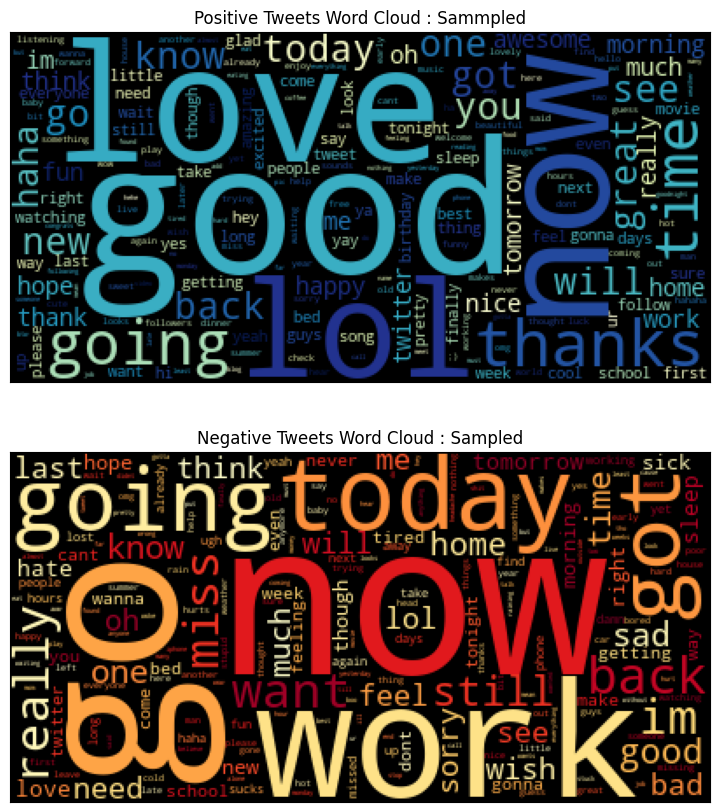

In [76]:
fig, axs = plt.subplots(2, 1, figsize = (10,10))
axs[0].imshow(WordCloud(max_words=200, colormap='YlGnBu').generate_from_frequencies(pos_pure))
axs[0].yaxis.set_visible(False)
axs[0].xaxis.set_visible(False)
axs[0].set_title("Positive Tweets Word Cloud : Sammpled")

axs[1].imshow(WordCloud(max_words=200, colormap='YlOrRd').generate_from_frequencies(neg_pure))
axs[1].yaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].set_title("Negative Tweets Word Cloud : Sampled")

plt.show()

------

In [67]:
print(pos_dict['now'])
print(neg_dict['now'])

print(pos_dict['now'] / max(pos_dict.values()))
print(neg_dict['now'] / max(neg_dict.values()))

41327
52579
0.6666397819108609
1.0


In [68]:
print(pos_pure['now'] / max(pos_dict.values()))
print(neg_pure['now'] / max(neg_dict.values()))

0.6666397819108609
1.0


52579